# Climate Change and Impacts in Africa

According to the [United Nations](https://www.un.org/en/climatechange/what-is-climate-change), Climate change refers to long-term shifts in temperatures and weather patterns. Such shifts can be natural, due to changes in the sun’s activity or large volcanic eruptions. But since the 1800s, **human activities** have been the main driver of climate change, primarily due to the burning of fossil fuels like coal, oil, and gas.

The consequences of climate change now include, among others, intense droughts, water scarcity, severe fires, rising sea levels, flooding, melting polar ice, catastrophic storms, and declining biodiversity.

You work for a Non-governmental organization tasked with reporting the state of climate change in Africa at the upcoming African Union Summit. The head of analytics has provided you with [IEA-EDGAR CO2 dataset](https://docs.google.com/spreadsheets/d/1cNhVUPKYP79AayGJp89_tXCJmHoxQO4cwiaseSziwbY/edit#gid=191680117) which you will clean, combine and analyze to create a report on the state of climate change in Africa. You will also provide insights on the impact of climate change on African regions (with four countries, one from each African region, as case studies). 

## Dataset

*The dataset, IEA-EDGAR CO2, is a component of the EDGAR (Emissions Database for Global Atmospheric Research) Community GHG database version 7.0 (2022) including or based on data from IEA (2021) Greenhouse Gas Emissions from Energy, www.iea.org/statistics, as modified by the Joint Research Centre. The data source was the [EDGARv7.0_GHG website](https://edgar.jrc.ec.europa.eu/dataset_ghg70) provided by Crippa *et. al.* (2022) and with [DOI](https://data.europa.eu/doi/10.2904/JRC_DATASET_EDGAR).*

The dataset contains three sheets - `IPCC 2006`, `1PCC 1996`, and `TOTALS BY COUNTRY` on the amount of CO2 (a greenhouse gas) generated by countries between 1970 and 2021. **You can inspect the dataset directly [here](https://docs.google.com/spreadsheets/d/1cNhVUPKYP79AayGJp89_tXCJmHoxQO4cwiaseSziwbY/edit#gid=191680117)**.

### TOTALS BY COUNTRY SHEET

This sheet contains the annual CO2 (kt) produced between 1970 - 2021 in each country. The relevant columns in this sheet are:

| Columns | Description |
| ------- | ------------|
| `C_group_IM24_sh` | The region of the world |
| `Country_code_A3` | The country code |
| `Name`            | The name of the country |
| `Y_1970 - Y_2021` | The amount of CO2 (kt) from 1970 - 2021 |


### IPCC 2006

These sheets contain the amount of CO2 by country and the industry responsible. 

| Columns | Description |
| ------- | ------------|
| `C_group_IM24_sh` | The region of the world |
| `Country_code_A3` | The country code |
| `Name`            | The name of the country |
| `Y_1970 - Y_2021` | The amount of CO2 (kt) from 1970 - 2021 |
| `ipcc_code_2006_for_standard_report_name` | The industry responsible for generating CO2 |

## Steps

1. Clean and tidy the datasets. 
2. Create a line plot to show the trend of `CO2` levels across the African regions.
3. Determine the relationship between time (`Year`) and `CO2` levels across the African regions.
4. Determine if there is a significant difference in the `CO2` levels among the African Regions.
5. Determine the most common (top 5) industries in each African region.
6. Determine the industry responsible for the most amount of CO2 (on average) in each African Region.
7. Predict the `CO2` levels (at each African region) in the year 2025.
8. Determine if `CO2` levels affect annual `temperature` in the selected African countries.

In [22]:
# Setup
import pandas as pd
import numpy as np
import pingouin
from sklearn.linear_model import LinearRegression
from statsmodels.regression.linear_model import OLS
import seaborn as sns
import matplotlib.pyplot as plt
import inspect

plt.style.use('ggplot')
# The sheet names containing our datasets
sheet_names = ['IPCC 2006', 'TOTALS BY COUNTRY']

# The column names of the dataset starts from rows 11
# Let's skip the first 10 rows
datasets = pd.read_excel('IEA_EDGAR_CO2_1970-2021.xlsx', sheet_name = sheet_names, skiprows = 10)

# we need only the African regions
african_regions = ['Eastern_Africa', 'Western_Africa', 'Southern_Africa', 'Northern_Africa']

ipcc_2006_africa = datasets['IPCC 2006'].query('C_group_IM24_sh in @african_regions')

totals_by_country_africa = datasets['TOTALS BY COUNTRY'].query('C_group_IM24_sh in @african_regions')


# Read the temperatures datasets containing four African countries
# One from each African Region:
# Nigeria:    West Africa
# Ethiopa :   East Africa
# Tunisia:    North Africa
# Mozambique: South Africa
temperatures = pd.read_csv('temperatures.csv')

## Step 1: Clean and tidy the datasets

### Tasks

- Rename `C_group_IM24_sh` to `Region`, `Country_code_A3` to `Code`, and `ipcc_code_2006_for_standard_report_name` to `Industry` in the corresponding African datasets.
- Drop `IPCC_annex`, `ipcc_code_2006_for_standard_report`, and `Substance` from the corresponding datasets.
- Melt `Y_1970` to `Y_2021` into a two columns `Year` and `CO2`. Drop rows where `CO2` is missing.
- Convert `Year` to `int` type.

In [24]:
# code here
rename_cols = {'C_group_IM24_sh':'Region', 'Country_code_A3':'Code', 'ipcc_code_2006_for_standard_report_name':'Industry'}
cols_drop = ['IPCC_annex','ipcc_code_2006_for_standard_report','Substance']

#rename colums
def drop_rename(df):
    df.rename(columns = rename_cols, errors='ignore', inplace=True)
    df.drop(columns = cols_drop, axis=1, errors='ignore', inplace = True) 
    return df

ipcc_2006_africa = drop_rename(ipcc_2006_africa)
totals_by_country_africa = drop_rename(totals_by_country_africa)

In [25]:
#function to melt the years and convert to int
def clean(df):
    value_vars = list(filter(lambda x: x.startswith('Y_'), df.columns))
    id_vars = list(set(df.columns).difference(value_vars))

     # melt
    long = df.melt(
            id_vars=id_vars,
            value_vars=value_vars,
            var_name='Year',
            value_name='CO2')

     # drop rows where co2 is missing
    long = long.dropna(subset=['CO2'])

     # convert year to integer
    long.Year = long.Year.str.replace('Y_', '').astype(int)

    return long

   
ipcc_2006_africa = clean(ipcc_2006_africa)
totals_by_country_africa = clean(totals_by_country_africa)





## Step 2: Show the trend of `CO2` levels across the African regions

### Tasks

- Using `totals_by_country_africa`, create a line plot of `CO2` vs. `Year` in each `Region` to show the trend of CO2 levels by year.

Text(0, 0.5, 'CO2 (kt)')

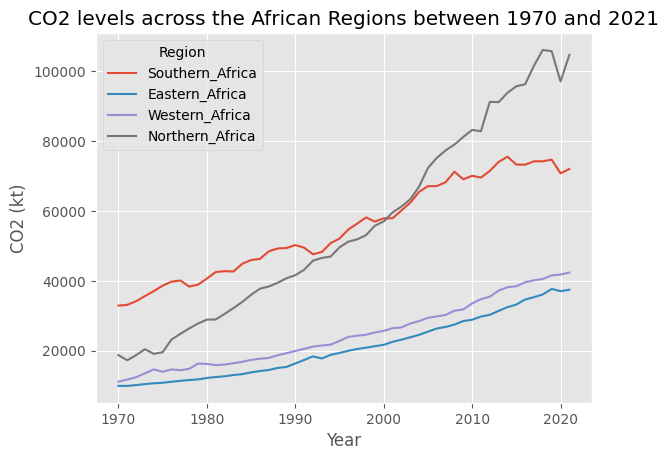

In [28]:
#code here
sns.lineplot(totals_by_country_africa, x='Year', y='CO2', hue='Region', ci=None)
plt.title('CO2 levels across the African Regions between 1970 and 2021')
plt.ylabel('CO2 (kt)')

## Step 3: Determine the relationship between time (`Year`) and `CO2` levels across the African regions


### Tasks

- Using the `totals_by_country_africa` dataset, conduct a Spearman's correlation to determine the relationship between time (`Year`) and `CO2` within each African `Region`.
- Save the results in a variable called `relationship_btw_time_CO2`.

In [30]:
#code here
group_reg = totals_by_country_africa.groupby('Region')[['Year', 'CO2']]
relationship_btw_time_CO2 = group_reg.corr(method='spearman'

## Step 4: Determine if there is a significant difference in the CO2 levels among the African Regions

### Tasks

- Using `totals_by_country_africa`, conduct an ANOVA using `pingouin.anova()` on the `CO2` by `Region`. Save the results as `aov_results`.
- Conduct a posthoc test (with Bonferroni correction) using `pingouin.pairwise_tests()` to find the source of the significant difference. Save the results as `pw_ttest_result`.
- Is it true that the `CO2` levels of the `Southern_Africa` and `Northern_Africa` region do not differ significantly? The previous task should provide you with the answer.

In [33]:
#  code here
#ANOVA Test
aov_results = pingouin.anova(
        data=totals_by_country_africa,
        dv='CO2',
        between='Region')

#Bonferroni test
pw_ttest_result = pingouin.pairwise_tests(
        data=totals_by_country_africa,
        dv='CO2',
        between='Region',
        padjust="bonf").round(3)

print(aov_results, "\n")
print(pw_ttest_result)

   Source  ddof1  ddof2          F         p-unc       np2
0  Region      3   2908  35.558065  1.455509e-22  0.035385 

  Contrast                A                B  ...  p-adjust       BF10  hedges
0   Region   Eastern_Africa  Northern_Africa  ...      bonf  1.554e+17  -0.801
1   Region   Eastern_Africa  Southern_Africa  ...      bonf  4.024e+08  -0.422
2   Region   Eastern_Africa   Western_Africa  ...      bonf      0.173  -0.059
3   Region  Northern_Africa  Southern_Africa  ...      bonf      0.079   0.005
4   Region  Northern_Africa   Western_Africa  ...      bonf  9.641e+10   0.418
5   Region  Southern_Africa   Western_Africa  ...      bonf  5.437e+05   0.335

[6 rows x 13 columns]


## Step 5: Determine the most common (top 5) industries in each African region.

### Tasks

- Group the `ipcc_2006_africa` data by `Region` and `Industry`.
- Count the occurrences of each `Industry` within each `Region` and name it `Count`.
- Sort the data within each region group by `Count` in descending order
- Get the top 5 industries for each region
- save it to variable `top_5_industries` for each region.

In [36]:
# code here
Region_Industry_group = ipcc_2006_africa.groupby(by=['Region', 'Industry']).size().reset_index(name='Count')

# Sort the data within each region group by Count in descending order
Region_Industry_group = Region_Industry_group.sort_values(['Region', 'Count'], ascending=[True, False])

print(Region_Industry_group)
# print(top_5_industries)

top_5_industries = Region_Industry_group.groupby('Region').head(5).reset_index(drop=True)
print(top_5_industries)

            Region                                       Industry  Count
18  Eastern_Africa                  Residential and other sectors   1454
9   Eastern_Africa      Manufacturing Industries and Construction   1383
8   Eastern_Africa  Main Activity Electricity and Heat Production   1174
19  Eastern_Africa            Road Transportation no resuspension    742
4   Eastern_Africa                               Glass Production    728
..             ...                                            ...    ...
89  Western_Africa                                    Solid Fuels    156
76  Western_Africa                                         Liming    136
75  Western_Africa                                Lime production     71
70  Western_Africa                              Chemical Industry     56
84  Western_Africa                           Other Transportation     42

[92 rows x 3 columns]
             Region                                        Industry  Count
0    Eastern_Africa       

## Step 6: Determine the industry responsible for the most amount of CO2 (on average) in each African Region

### Tasks

- Group the `ipcc_2006_africa` data by `Region` and `Industry`.
- Calculate the average `CO2` emissions for each group.
- Find the `Industry` with the maximum average `CO2` emissions in each region.

In [39]:
# code here
grouped = ipcc_2006_africa.groupby(['Region', 'Industry'])[
        'CO2'].mean().reset_index()


max_co2_industries = grouped.loc[grouped.groupby(
        'Region')['CO2'].idxmax()].reset_index(drop=True)

## Step 7: Predict the `CO2` levels (at each African region) in the year 2025

### Tasks

- Create an instance of `LinearRegression()` and save it as `reg`.
- Fit a linear model of `CO2` (in log base 10) by `Year` and `Region` using `reg.fit()`.
- Predict the values of `CO2` using the `reg.predict()` and the data provided. Save the result as `predicted_co2`. 
- Convert `predicted_co2` values from log base 10 to decimals and round to 2 d.p using `np.round()`.

In [42]:
# code here
# data provided for you
from sklearn.linear_model import LinearRegression

newdata = pd.DataFrame({ 'Year': 2025, 'Region': african_regions })
newdata = pd.get_dummies(newdata)

reg = LinearRegression()
target = np.log10(totals_by_country_africa['CO2'])
feats = pd.get_dummies(totals_by_country_africa[['Year', 'Region']])
reg.fit(feats, target)
predicted_co2 = reg.predict(newdata)
predicted_co2 = np.round(10**predicted_co2, 2)

In [43]:
# DO NOT MODIFY THIS CELL
# Run this cell to determine if you've done the above correctly
# If there are no error messages, you are correct :)
# tests
runner.check_task_7(predicted_co2)

In [44]:
# Uncomment and run to view solution seven
# print(inspect.getsource(solutions.solution_seven))

## Step 8: Determine if CO2 levels affect annual temperature in the selected African countries

### Tasks

- Select `Name`, `Year` and `CO2` of countries `countries`. Save the result as `selected_countries`.
- Convert `temperatures` dataset from wide to long format. Set the new column names to `Name` and `Temperature`. Save the result as `temp_long`.
- Perform an inner join between `selected_countries` and `temp_long` on `Name` and `Year`. Save the result as `joined`.
- Create a linear model of `Temperature` by `CO2` and `Name`. Save the result as `model_temp`. 
- A one unit rise in log10 `CO2` leads to how many degrees rise in temperature? Run `model_temp.summary()` to find out!
- What is the adjusted R squared value of the model?

In [45]:
#code here
countries = ["Ethiopia", "Mozambique", "Nigeria", "Tunisia"]

selected_countries = totals_by_country_africa[['Name', 'Year', 'CO2']].query('Name in @countries')
                                               

temp_long = temperatures.melt(id_vars=['Year'],value_vars=countries, var_name='Name', value_name='Temperature')    
                                               
joined = pd.merge(selected_countries, temp_long, on=['Name', 'Year'], how='inner')   

# Creating the ML model
model_temp = OLS.from_formula("Temperature ~ np.log10(CO2) + Name", data = joined).fit()
model_temp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Temperature   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     3241.
Date:                Sat, 26 Aug 2023   Prob (F-statistic):          1.22e-182
Time:                        18:52:58   Log-Likelihood:                -54.347
No. Observations:                 208   AIC:                             118.7
Df Residuals:                     203   BIC:                             135.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             13.4981      0.583     23.138      0.000      12.348      14.648
Name[T.Mozambique]     2.0759      0.090     23.021      0.000       1.898       2.254
Name[T.Nigeria]        2.8345      0.092     30.884      0.000       2.654       3.016
Name[T.Tunisia]       -1.6254      0.104    -15.673      0.000      -1.830      -1.421
np.log10(CO2)          1.9472      0.117     16.620      0.000       1.716       2.178
==============================================================================
Omnibus:                        3.230   Durbin-Watson:                   1.896
Prob(Omnibus):                  0.199   Jarque-Bera (JB):                2.985
Skew:                          -0.291   Prob(JB):                        0.225
Kurtosis:                       3.073   Cond. No.                         136.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can now see the accuracy of the model is satisfactory which is 98%. This model can enabke us to predict the CO2 levels (at each African region) for the future!(in the year 2025)